In [25]:
!pip install stellargraph[demos]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import json
import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

import stellargraph as sg
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive 
import sys


drive.mount('/content/drive', force_remount=True) 
colab_path="/content/drive/My Drive/csci2470/project"
sys.path.append(colab_path)

Mounted at /content/drive


In [27]:
batch_size = 200
epochs = 50
train_size = 0.7
test_size = 0.3
num_samples = [8, 4]
num_workers = 4

In [28]:
# dataset = datasets.MovieLens()
# display(HTML(dataset.description))
# G, edges_with_ratings = dataset.load()
# print(G.info())

# user = pd.DataFrame(
#     {"duration": [2, 4, 6, 2, 4, 6, 2, 4, 6, 2, 4, 6, 2, 4, 6, 2, 4, 6, 2, 4]},
#     index = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"]
# )

# subreddit = pd.DataFrame(
#     index = ["music", "drama", "game", "relation"]
# )

# join = pd.DataFrame(
#     {
#         "source": ["1", "1", "2", "3", "3", "4", "5", "6", "6", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"], 
#         "target": ["music", "drama", "music", "drama", "game", "game", "music", "music", "drama", "game", "music", "drama", "game", "relation", "music", "drama", "game", "relation", "music", "drama", "game", "relation", "game", "relation"],
#         "freq": [4, 8, 2, 12, 10, 4, 2, 4, 6, 6, 2, 4, 6, 2, 4, 6, 2, 4, 6, 2, 4, 6, 7, 8]
#      }
# )

# user = pd.DataFrame(
#     {"user_feat1": user_nodes['user_feat1'], "user_feat2": user_nodes['user_feat2']},
#     index = user_nodes['username'],
# )

# subreddit = pd.DataFrame(
#     {"subreddit_feat1": subreddit_nodes['subreddit_feat1']},
#     index = subreddit_nodes['subreddit'],
# )

In [29]:
pd.set_option('display.width', 100)

def u(users):
    return "u_" + users.astype(str)

def s(subreddits):
    return "s_" + subreddits.astype(str)


# data loading
user_nodes = pd.read_csv(f"{colab_path}/nodes_user_50K_mbti.csv")
subreddit_nodes = pd.read_csv(f"{colab_path}/nodes_subreddit_50K_keywords.csv")
edges = pd.read_csv(f"{colab_path}/edges_50K.csv")



# data clean up
'''
user feature:       comment_karma, link_karma, is_mod, mbti
subreddit feature:  genre
edge feature:       tot_comment
'''
user_nodes = user_nodes.drop(columns=['Unnamed: 0', 'words', 'is_employee', 'is_friend'])

idx = user_nodes.comment_karma != 'no_karma'
user_nodes = user_nodes[idx]

idx = user_nodes.link_karma != 'no_karma'
user_nodes = user_nodes[idx]

idx = user_nodes.is_mod != 'no_is_mod'
user_nodes = user_nodes[idx]

user_nodes = user_nodes[~((user_nodes['comment_karma'] == 'something_wrong_with_this_user' ) | (user_nodes['link_karma'] == 'something_wrong_with_this_user' ) | (user_nodes['is_mod'] == 'something_wrong_with_this_user' ))]

user_nodes = user_nodes[user_nodes.mbti.notnull()]


subreddit_nodes = subreddit_nodes.drop(columns=['words'])
subreddit_nodes = subreddit_nodes[subreddit_nodes.genre != 'no_description']
subreddit_nodes = subreddit_nodes[subreddit_nodes.genre != 'something_wrong_with_this_user']
subreddit_nodes = subreddit_nodes.dropna()


edges = edges[edges.username.isin(user_nodes.username)]
edges = edges[edges.subreddit.isin(subreddit_nodes.subreddit)]


# feature preprocessing
user_nodes['username'] = u(user_nodes['username'])
user_nodes.set_index("username", inplace=True)

def min_max_scaling(column):
  return (column - column.min()) / (column.max() - column.min())
# feature_encoding = preprocessing.OneHotEncoder(sparse=False)
# mbti_ohe = feature_encoding.fit_transform(user_nodes[['mbti']])
# mod_ohe = feature_encoding.fit_transform(user_nodes[['is_mod']])
# scaler = preprocessing.MinMaxScaler()
# comment_scaled = scaler.fit_transform(user_nodes[['comment_karma']])
# link_scaled = scaler.fit_transform(user_nodes[['link_karma']])

user_nodes = user_nodes.join(pd.get_dummies(user_nodes['mbti'], prefix='mbti'))
user_nodes = user_nodes.drop(columns=['mbti'])
user_nodes = user_nodes.join(pd.get_dummies(user_nodes['is_mod'], prefix='is_mod'))
user_nodes = user_nodes.drop(columns=['is_mod'])
user_nodes['comment_karma'] = user_nodes['comment_karma'].astype(int)
user_nodes['link_karma'] = user_nodes['link_karma'].astype(int)
user_nodes['comment_karma'] = min_max_scaling(user_nodes['comment_karma'])
user_nodes['link_karma'] = min_max_scaling(user_nodes['link_karma'])


subreddit_nodes['subreddit'] = s(subreddit_nodes['subreddit'])
subreddit_nodes.set_index("subreddit", inplace=True)
# subreddit_nodes['genre'] = subreddit_nodes['genre'].astype('string')
# genres = np.unique('|'.join(subreddit_nodes['genre']).split('|')).flatten().tolist()
# subreddit_nodes = subreddit_nodes.reindex(subreddit_nodes.columns.tolist() + genres, axis=1, fill_value=0)
# for index, row in subreddit_nodes.iterrows():
#   for val in row.genre.str.split('|'):
#       if val != 'NA':
#         subreddit_nodes.loc[index, val] = 1
subreddit_nodes.drop('genre', axis=1, inplace=True)
subreddit_nodes['rand_feat'] = [1] * len(subreddit_nodes.index)


edges["username"] = u(edges["username"])
edges["subreddit"] = s(edges["subreddit"])


# construct graph
G = sg.StellarGraph(
    {"user": user_nodes, "subreddit": subreddit_nodes},
    {"freq": edges[["username", "subreddit"]]},
    source_column="username",
    target_column="subreddit",
  )

print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 17540, Edges: 28083

 Node types:
  user: [9012]
    Features: float32 vector, length 20
    Edge types: user-freq->subreddit
  subreddit: [8528]
    Features: float32 vector, length 1
    Edge types: subreddit-freq->user

 Edge types:
    subreddit-freq->user: [28083]
        Weights: all 1 (default)
        Features: none


In [30]:
user_nodes.info()

# clean up keywords: 
# something_wrong_with_this_user, no_karma, no_is_mod, no_is_employee, no_is_friend, None

<class 'pandas.core.frame.DataFrame'>
Index: 9012 entries, u_mrtransisteur to u__jlb
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   comment_karma  9012 non-null   float64
 1   link_karma     9012 non-null   float64
 2   mbti_0.0       9012 non-null   uint8  
 3   mbti_1.0       9012 non-null   uint8  
 4   mbti_2.0       9012 non-null   uint8  
 5   mbti_3.0       9012 non-null   uint8  
 6   mbti_4.0       9012 non-null   uint8  
 7   mbti_5.0       9012 non-null   uint8  
 8   mbti_6.0       9012 non-null   uint8  
 9   mbti_7.0       9012 non-null   uint8  
 10  mbti_8.0       9012 non-null   uint8  
 11  mbti_9.0       9012 non-null   uint8  
 12  mbti_10.0      9012 non-null   uint8  
 13  mbti_11.0      9012 non-null   uint8  
 14  mbti_12.0      9012 non-null   uint8  
 15  mbti_13.0      9012 non-null   uint8  
 16  mbti_14.0      9012 non-null   uint8  
 17  mbti_15.0      9012 non-null   uint8  
 1

In [31]:
subreddit_nodes.head()

# clean up keywords: 
# something_wrong_with_this_subreddit, no_description

,rand_feat
subreddit,
s_ethereum,1
s_batman,1
s_wowthissubexists,1
s_RocketLeagueExchange,1
s_EatCheapAndHealthy,1


In [32]:
edges.head()

,username,subreddit,tot_comments
0,u_mrtransisteur,s_ethereum,6
2,u_soroushm,s_wowthissubexists,1
3,u_lickmydicknipple,s_RocketLeagueExchange,379
4,u_ilickyboomboom,s_EatCheapAndHealthy,1
5,u_crazypants88,s_SuicideWatch,6


In [33]:
edges_train, edges_test = model_selection.train_test_split(
    edges, train_size=train_size, test_size=test_size
)

edgelist_train = list(edges_train[["username", "subreddit"]].itertuples(index=False))
edgelist_test = list(edges_test[["username", "subreddit"]].itertuples(index=False))

labels_train = edges_train["tot_comments"]
labels_test = edges_test["tot_comments"]


# edge_splitter_test = sg.data.EdgeSplitter(G)
# graph_test, edges_test, labels_test = edge_splitter_test.train_test_split(
#     p=0.2, method="global", edge_label="default"
# )

# edge_splitter_train = sg.data.EdgeSplitter(graph_test, G)
# graph_train, edges_train, labels_train = edge_splitter_train.train_test_split(
#     p=0.7, method="global", edge_label="default"
# )

generator = HinSAGELinkGenerator(
    G, batch_size, num_samples, head_node_types=["user", "subreddit"]
)

train_gen = generator.flow(edgelist_train, labels_train, shuffle=True)
test_gen = generator.flow(edgelist_test, labels_test)

generator.schema.type_adjacency_list(generator.head_node_types, len(num_samples))

[('user', [2]),
 ('subreddit', [3]),
 ('subreddit', [4]),
 ('user', [5]),
 ('user', []),
 ('subreddit', [])]

In [34]:
hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes, generator=generator, bias=True, dropout=0.0
)
x_inp, x_out = hinsage.in_out_tensors()
score_prediction = link_regression(edge_embedding_method="concat")(x_out)

import tensorflow.keras.backend as K

def root_mean_square_error(s_true, s_pred):
    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))


model = Model(inputs=x_inp, outputs=score_prediction)
model.compile(
    optimizer=optimizers.Adam(lr=1e-3),
    loss=losses.mean_squared_error,
    metrics=[root_mean_square_error, metrics.mae],
)

model.summary()

link_regression: using 'concat' method to combine node embeddings into edge embeddings
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 8, 1)]       0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 32, 20)]     0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 32, 1)]      0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 1, 20)]      0           []                               
     

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 dense_2 (Dense)                (None, 1)            65          ['link_embedding_2[0][0]']       
                                                                                                  
 reshape_26 (Reshape)           (None, 1)            0           ['dense_2[0][0]']                
                                                                                                  
Total params: 2,913
Trainable params: 2,913
Non-trainable params: 0
__________________________________________________________________________________________________


In [35]:
test_metrics = model.evaluate(
    test_gen, verbose=1, use_multiprocessing=False, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

43/43 [==============================] - 6s 84ms/step - loss: 5125.6211 - root_mean_square_error: 68.5594 - mean_absolute_error: 17.0868
Untrained model's Test Evaluation:
	loss: 5125.6211
	root_mean_square_error: 68.5594
	mean_absolute_error: 17.0868


Epoch 1/50
99/99 [==============================] - 16s 137ms/step - loss: 4606.9946 - root_mean_square_error: 64.0011 - mean_absolute_error: 15.7310 - val_loss: 5039.8296 - val_root_mean_square_error: 67.8777 - val_mean_absolute_error: 15.7133
Epoch 2/50
99/99 [==============================] - 14s 139ms/step - loss: 4559.2925 - root_mean_square_error: 62.1272 - mean_absolute_error: 15.5225 - val_loss: 5008.6992 - val_root_mean_square_error: 67.6321 - val_mean_absolute_error: 15.8560
Epoch 3/50
99/99 [==============================] - 14s 142ms/step - loss: 4531.3481 - root_mean_square_error: 63.2049 - mean_absolute_error: 15.7443 - val_loss: 4981.8525 - val_root_mean_square_error: 67.4219 - val_mean_absolute_error: 16.1434
Epoch 4/50
99/99 [==============================] - 14s 143ms/step - loss: 4506.7119 - root_mean_square_error: 61.9262 - mean_absolute_error: 16.0486 - val_loss: 4958.5557 - val_root_mean_square_error: 67.2412 - val_mean_absolute_error: 16.5029
Epoch 5/50
99/99 [==

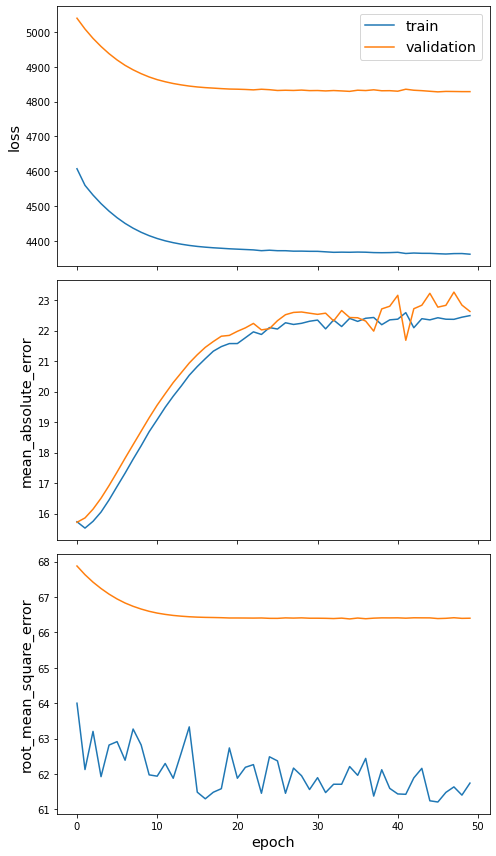

In [36]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    workers=num_workers,
)

sg.utils.plot_history(history)

In [37]:
test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

43/43 [==============================] - 4s 85ms/step - loss: 4828.3423 - root_mean_square_error: 66.3966 - mean_absolute_error: 22.6571
Test Evaluation:
	loss: 4828.3423
	root_mean_square_error: 66.3966
	mean_absolute_error: 22.6571
